In [ ]:
import pandas as pd
import glob
import numpy as np
import datetime
import matplotlib.pyplot as plt
import statsmodels
import tensorflow as tf
from datetime import timedelta, date, datetime
import warnings
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score, precision_score, recall_score

# define functions


## plot series

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

## windowed dataset

In [ ]:
def create_dataset(series, batch_size, shuffle_buffer):
    """Generates dataset

    Args:
      series (array of float) - contains the values of the time series
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time series as inputs and outputs
    """

    # Convert the array into a TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((series, series))

    # Optionally shuffle and batch the dataset
    dataset = dataset.shuffle(shuffle_buffer).batch(batch_size).prefetch(1)

    return dataset

## model forecast

In [ ]:
def model_forecast(model, series, forcaste_size, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=forcaste_size, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

## plot loss

In [ ]:
def plot_loss(epoches, train_loss, val_loss=None, start=0):
    if val_loss:
        # Create subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

        # Plot the first data on the first subplot
        ax1.plot(range(start, epoches), train_loss[start:], 'b', label='Training Loss')

        # Plot the second data on the second subplot
        ax2.plot(range(start, epoches), val_loss[start:], 'b', label='validation Loss')

        # Customize the plots if needed
        ax1.set_title('Training Loss')
        ax1.set_xlabel('epoches')
        ax1.set_ylabel('error')
        ax1.legend()

        ax2.set_title('validation Loss')
        ax2.set_xlabel('epoches')
        ax2.set_ylabel('error')
        ax2.legend()

        # Adjust layout to prevent overlapping
        plt.tight_layout()

    else:
        # Plot all but the first n
        plt.plot(range(start, epoches), train_loss[start:], 'b', label='Training Loss')

    # Display the plots
    plt.show()

## normalize data

In [ ]:
def normalize_data(data):
    """ scale each row (observation) between 0 and 1
    """

    min_values = np.min(data, axis=1, keepdims=True)
    max_values = np.max(data, axis=1, keepdims=True)
    scaled_data = (data - min_values) / (max_values - min_values + 0.000000000001)

    return scaled_data

## downsampling function

In [ ]:
def downsampling(data, downsample_factor, take_mean=False):
    if take_mean:
        return np.mean(data[:, :data.shape[1] // downsample_factor * downsample_factor].reshape(data.shape[0], -1, downsample_factor), axis=2)
    return data[:, ::downsample_factor]

## anomaly detection

In [1]:
def detection(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mse(reconstructions, data)
    return loss > threshold

## show prediction status

In [ ]:
def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

# download dataset from kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install -q kaggle

! mkdir ~/.kaggle

! cp /content/drive/MyDrive/ai_projects/kaggle.json ~/.kaggle

! chmod 600  ~/.kaggle/kaggle.json

! kaggle datasets download nagasai524/anomaly-detection-in-helicopter

! unzip /content/anomaly-detection-in-helicopter.zip

100% 622M/624M [00:32<00:00, 21.7MB/s]
100% 624M/624M [00:32<00:00, 20.0MB/s]
Archive:  /content/anomaly-detection-in-helicopter.zip
  inflating: dfvalid_groundtruth.csv  
  inflating: train_df.csv            
  inflating: validation_df.csv       


# Exploratory data analysis

## labels

In [ ]:
labels = pd.read_csv('dfvalid_groundtruth.csv')['anomaly'].to_numpy()

## train dataset

In [ ]:
train_series = pd.read_csv('train_df.csv', index_col=0, low_memory=False).to_numpy()

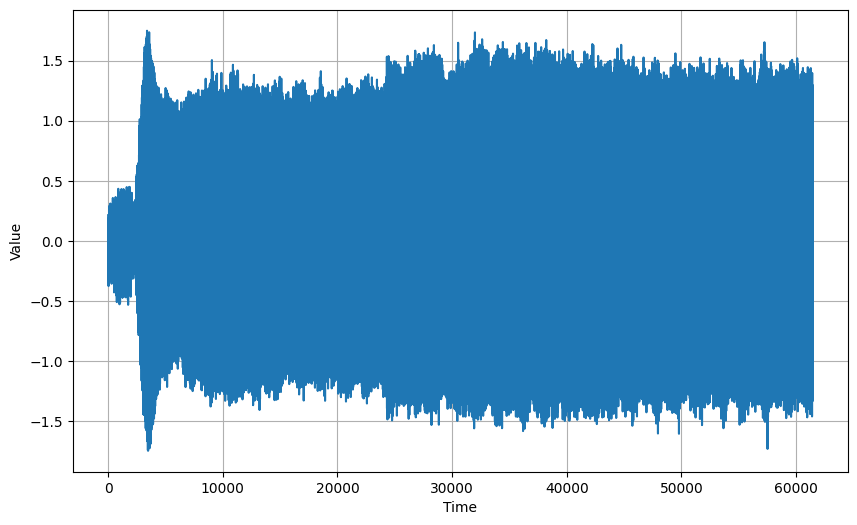

In [ ]:
plot_series(np.arange(train_series.shape[1]), train_series[2])

## validation dataset

In [ ]:
val_series = pd.read_csv('validation_df.csv', index_col=0, low_memory=False).to_numpy()

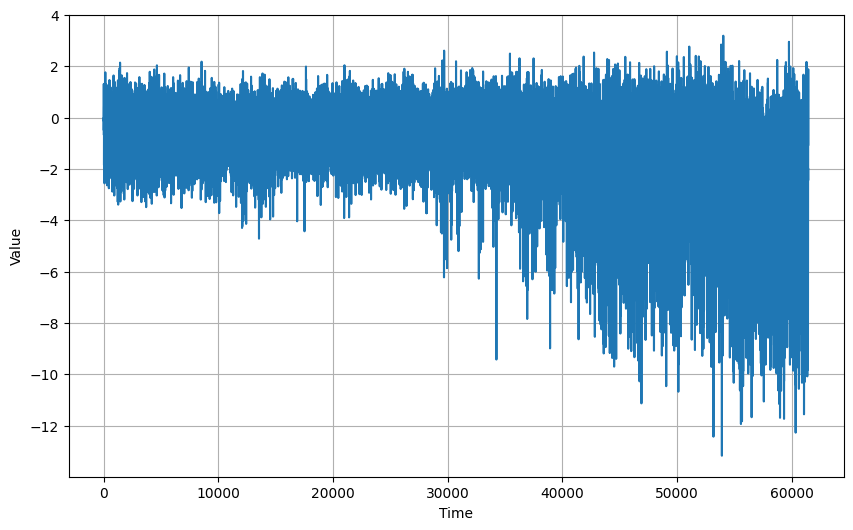

In [ ]:
# abnormal observation
plot_series(np.arange(val_series.shape[1]), val_series[5])

#  prepare tensorflow dataset and features

## downsampling

In [ ]:
train_series_sampled = downsampling(train_series, 10, take_mean=True)
val_series_sampled = downsampling(val_series, 10, take_mean=True)

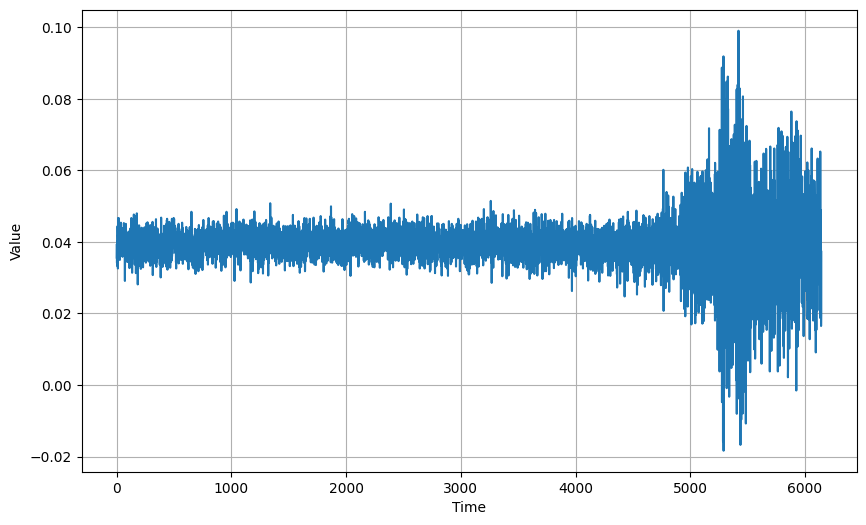

In [ ]:
plot_series(np.arange(train_series_sampled.shape[1]), train_series_sampled[0])

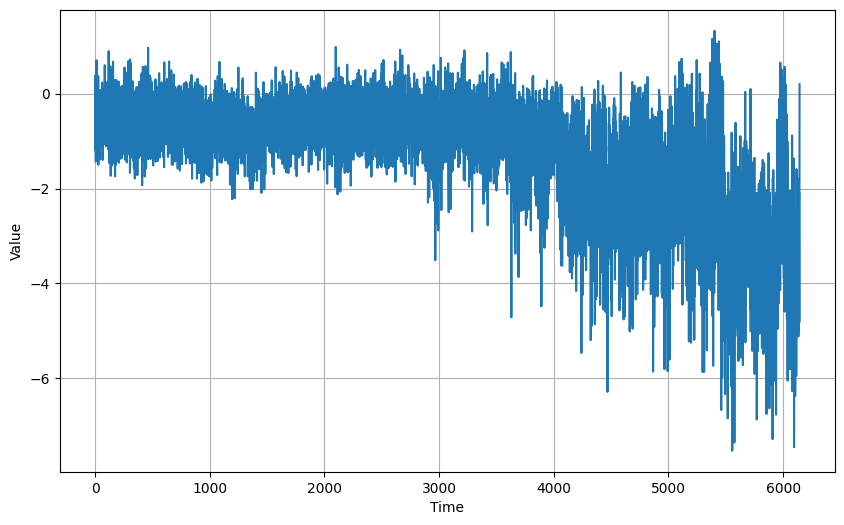

In [ ]:
plot_series(np.arange(val_series_sampled.shape[1]), val_series_sampled[5])

In [ ]:
train_series_sampled.shape

(1677, 6144)

In [ ]:
val_series_sampled.shape

(594, 6144)

## Prepare Features and Labels

In [ ]:
# Parameters
batch_size = 256
shuffle_buffer_size = 1000

# Generate the dataset windows
train_dataset = create_dataset(train_series_sampled, batch_size, shuffle_buffer_size)

# Build the Model

In [ ]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(train_series_sampled.shape[1], input_shape=(train_series_sampled.shape[1], ))
    , tf.keras.layers.Dense(128
                        # , kernel_regularizer=tf.keras.regularizers.l2(0.00001)
                        )
    , tf.keras.layers.Dense(64
                        # , kernel_regularizer=tf.keras.regularizers.l2(0.00001)
                        )
    , tf.keras.layers.Dense(32
                        # , kernel_regularizer=tf.keras.regularizers.l2(0.00001)
                        )
    , tf.keras.layers.Dense(16
                        # , kernel_regularizer=tf.keras.regularizers.l2(0.00001)
                        )
    , tf.keras.layers.Dense(32
                        # , kernel_regularizer=tf.keras.regularizers.l2(0.00001)
                        )
    , tf.keras.layers.Dense(64
                        # , kernel_regularizer=tf.keras.regularizers.l2(0.00001)
                        )
    , tf.keras.layers.Dense(128
                        # , kernel_regularizer=tf.keras.regularizers.l2(0.00001)
                        )
    , tf.keras.layers.Dense(train_series_sampled.shape[1])
])

# Print the model summary
print(model.summary())

# compile model with specified parameters
model.compile(
                  # loss=tf.keras.losses.Huber(),
                loss = 'mse',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)
                 )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6144)              37754880  
                                                                 
 dense_1 (Dense)             (None, 128)               786560    
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 32)                544       
                                                                 
 dense_6 (Dense)             (None, 64)                2

## Train the Model

In [ ]:
# Train the model
epoches = 500
history = model.fit(train_dataset, epochs=epoches)

Epoch 1/500
7/7 [==============================] - 4s 37ms/step - loss: 0.1772
Epoch 2/500
7/7 [==============================] - 0s 33ms/step - loss: 0.1855
Epoch 3/500
7/7 [==============================] - 0s 31ms/step - loss: 0.1695
Epoch 4/500
7/7 [==============================] - 0s 29ms/step - loss: 0.1652
Epoch 5/500
7/7 [==============================] - 0s 29ms/step - loss: 0.1608
Epoch 6/500
7/7 [==============================] - 0s 30ms/step - loss: 0.1584
Epoch 7/500
7/7 [==============================] - 0s 29ms/step - loss: 0.1560
Epoch 8/500
7/7 [==============================] - 0s 29ms/step - loss: 0.1511
Epoch 9/500
7/7 [==============================] - 0s 29ms/step - loss: 0.1471
Epoch 10/500
7/7 [==============================] - 0s 29ms/step - loss: 0.1441
Epoch 11/500
7/7 [==============================] - 0s 29ms/step - loss: 0.1430
Epoch 12/500
7/7 [==============================] - 0s 29ms/step - loss: 0.1423
Epoch 13/500
7/7 [==============================]

### ploting the train loss

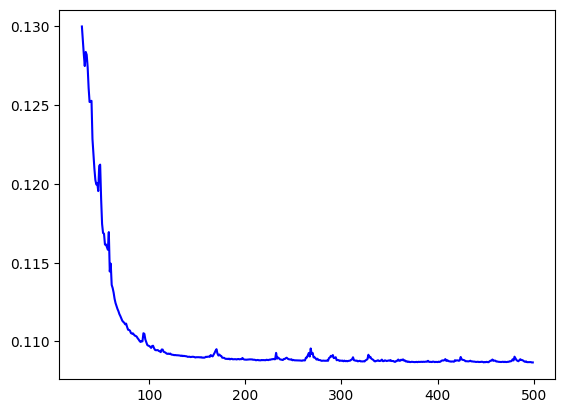

In [ ]:
plot_loss(epoches, history.history['loss'], start=30)

# reconstruction

In [ ]:
reconstructions = model.predict(train_series_sampled)
train_loss = tf.keras.losses.mse(reconstructions, train_series_sampled)

53/53 [==============================] - 0s 4ms/step


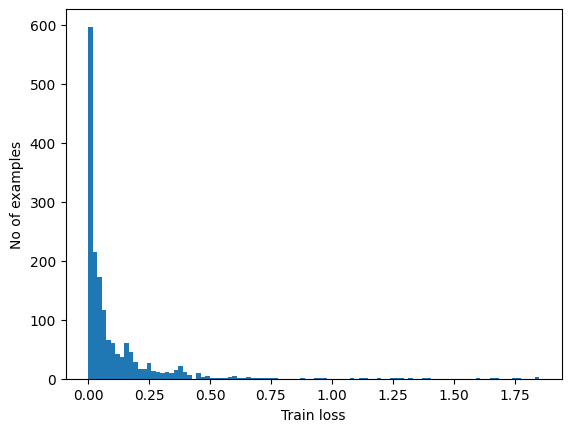

In [ ]:
plt.hist(train_loss[None,:], bins=100)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

# Detect anomalies

In [ ]:
threshold = np.mean(train_loss)
print("Threshold: ", threshold)

Threshold:  0.1085576014990638


In [ ]:
prediction = detection(model, val_series_sampled, threshold)

In [ ]:
print_stats(prediction, labels)

Accuracy = 0.8703703703703703
Precision = 0.9471544715447154
Recall = 0.7845117845117845


# distribution of reconstruction error for normal and abnormal data

10/10 [==============================] - 0s 4ms/step


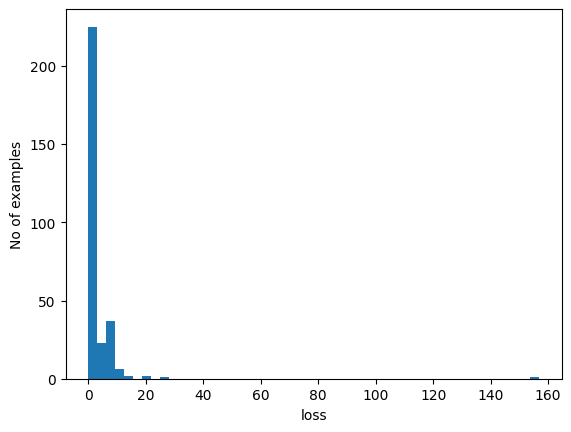

In [ ]:
anomaly = val_series_sampled[labels == 1]

anomaly_loss = tf.keras.losses.mse(model.predict(anomaly), anomaly)

plt.hist(anomaly_loss[None,:], bins=50)
plt.xlabel("loss")
plt.ylabel("No of examples")
plt.show()

10/10 [==============================] - 0s 4ms/step


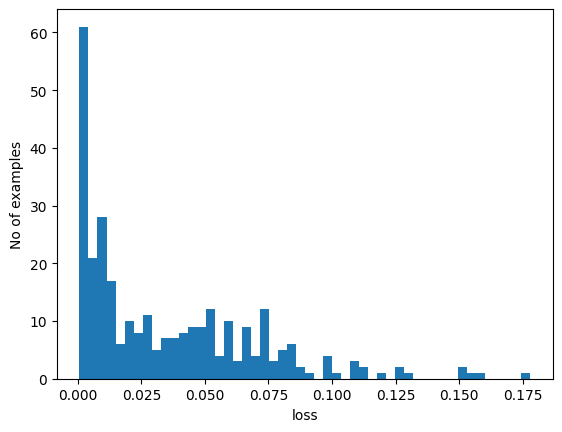

In [ ]:
normal = val_series_sampled[labels == 0]

normal_loss = tf.keras.losses.mse(model.predict(normal), normal)

plt.hist(normal_loss[None,:], bins=50)
plt.xlabel("loss")
plt.ylabel("No of examples")
plt.show()